# 1. Chargement et préparation des données

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Chargement du dataset
df = pd.read_csv("./dataset/insurance.csv")

print(f"✓ Dataset chargé : {df.shape[0]} lignes et {df.shape[1]} colonnes")

# Valeurs manquantes
print("\nValeurs manquantes dans le dataset final :")
print(df.isnull().sum())
print("\n✓ Aucune valeur manquante")

# Traitement des doublons
print("\nNombre de lignes dupliquées : ", df.duplicated().sum(), "\n")

display(df[df.duplicated(keep=False)])

df = df.drop_duplicates()
print("\n✓ Doublon supprimé")


✓ Dataset chargé : 1338 lignes et 7 colonnes

Valeurs manquantes dans le dataset final :
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

✓ Aucune valeur manquante

Nombre de lignes dupliquées :  1 



,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631



✓ Doublon supprimé


# 2. Feature engineering

In [30]:
# Récupération des variables pertinentes pour le modèle (pas région car pas d'impact)
df_model = df[["sex", "smoker", "age", "bmi", "children", "region", "charges"]]

# Label encoding pour le sexe
df_model["sex_encoded"] = (df_model["sex"].map({"male": 0, "female": 1}))


# Label encoding pour smoker
df_model["smoker_encoded"] = (df_model["smoker"]).map({"no": 0, "yes": 1})

# One-Hot encoding pour regions
region_dummies = pd.get_dummies(df_model["region"], drop_first=True)
df_model = pd.concat([df_model, region_dummies], axis=1)

df_model.head()

/tmp/ipykernel_16964/75657955.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model["sex_encoded"] = (df_model["sex"].map({"male": 0, "female": 1}))
/tmp/ipykernel_16964/75657955.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model["smoker_encoded"] = (df_model["smoker"]).map({"no": 0, "yes": 1})


,sex,smoker,age,bmi,children,region,charges,sex_encoded,smoker_encoded,northwest,southeast,southwest
0,female,yes,19,27.900,0,southwest,16884.92400,1,1,False,False,True
1,male,no,18,33.770,1,southeast,1725.55230,0,0,False,True,False
2,male,no,28,33.000,3,southeast,4449.46200,0,0,False,True,False
3,male,no,33,22.705,0,northwest,21984.47061,0,0,True,False,False
4,male,no,32,28.880,0,northwest,3866.85520,0,0,True,False,False


In [31]:
features_to_keep = [
    "smoker_encoded",
    "bmi",
    "age",
    "sex_encoded",
    "children",
    "northwest",
    "southeast",
    "southwest"
]

print(f"Dataset final : {df_model[features_to_keep].shape[0]} lignes et {df_model[features_to_keep].shape[1]} colonnes")
print("\nAperçu du dataset :")
df_model[features_to_keep].head()

Dataset final : 1337 lignes et 8 colonnes

Aperçu du dataset :


,smoker_encoded,bmi,age,sex_encoded,children,northwest,southeast,southwest
0,1,27.900,19,1,0,False,False,True
1,0,33.770,18,0,1,False,True,False
2,0,33.000,28,0,3,False,True,False
3,0,22.705,33,0,0,True,False,False
4,0,28.880,32,0,0,True,False,False


# 3. Split train-test

In [32]:
# Division des données : 80 % train, 20 % test

def split_data_for_model(features_to_keep, target, stratify):
    X = df_model[features_to_keep]
    y = target

    print("Features (X) :")
    print(f"  - Shape : {X.shape}")
    print(f"  - Colonnes : {X.columns.tolist()}")
    print(f"\nCible (y) :")
    print(f"  - Shape : {y.shape[0]}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size = 0.2,
        random_state = 42,
        stratify = X[stratify]
    )

    print("\nDivision des données :")
    print(f"  - Entraînement : {X_train.shape[0]} exemples ({X_train.shape[0]/len(X)*100:.1f} %)")
    print(f"  - Test : {X_test.shape[0]} exemples ({X_test.shape[0]/len(X)*100:.1f} %)")
    print(f"\nDistribution de la cible dans l'entraînement :")
    display(y_train.describe().round(2))
    print(f"\nDistribution de la cible dans le test :")
    display(y_test.describe().round(2))

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data_for_model(features_to_keep, df_model["charges"], "smoker_encoded")

# X = df_model[features_to_keep]
# y = df_model["charges"]

# X1 = X
# y_log = np.log(df_model["charges"])

# print("Features (X) :")
# print(f"  - Shape : {X.shape}")
# print(f"  - Colonnes : {X.columns.tolist()}")
# print(f"\nCible (y) :")
# print(f"  - Shape : {y.shape[0]}")

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size = 0.2,
#     random_state = 42,
#     stratify = X["smoker_encoded"]
# )

# print("\nDivision des données :")
# print(f"  - Entraînement : {X_train.shape[0]} exemples ({X_train.shape[0]/len(X)*100:.1f} %)")
# print(f"  - Test : {X_test.shape[0]} exemples ({X_test.shape[0]/len(X)*100:.1f} %)")
# print(f"\nDistribution de la cible dans l'entraînement :")
# display(y_train.describe().round(2))
# print(f"\nDistribution de la cible dans le test :")
# display(y_test.describe().round(2))


Features (X) :
  - Shape : (1337, 8)
  - Colonnes : ['smoker_encoded', 'bmi', 'age', 'sex_encoded', 'children', 'northwest', 'southeast', 'southwest']

Cible (y) :
  - Shape : 1337

Division des données :
  - Entraînement : 1069 exemples (80.0 %)
  - Test : 268 exemples (20.0 %)

Distribution de la cible dans l'entraînement :


count     1069.00
mean     13355.93
std      12135.07
min       1121.87
25%       4753.64
50%       9414.92
75%      17178.68
max      63770.43
Name: charges, dtype: float64


Distribution de la cible dans le test :


count      268.00
mean     12972.74
std      12028.94
min       1131.51
25%       4644.03
50%       9296.36
75%      14452.79
max      52590.83
Name: charges, dtype: float64

In [33]:
# Division des données pour le log

X_log_train, X_log_test, y_log_train, y_log_test = split_data_for_model(features_to_keep, np.log(df_model["charges"]), "smoker_encoded")


Features (X) :
  - Shape : (1337, 8)
  - Colonnes : ['smoker_encoded', 'bmi', 'age', 'sex_encoded', 'children', 'northwest', 'southeast', 'southwest']

Cible (y) :
  - Shape : 1337

Division des données :
  - Entraînement : 1069 exemples (80.0 %)
  - Test : 268 exemples (20.0 %)

Distribution de la cible dans l'entraînement :


count    1069.00
mean        9.11
std         0.92
min         7.02
25%         8.47
50%         9.15
75%         9.75
max        11.06
Name: charges, dtype: float64


Distribution de la cible dans le test :


count    268.00
mean       9.07
std        0.91
min        7.03
25%        8.44
50%        9.14
75%        9.58
max       10.87
Name: charges, dtype: float64

# 4. Mise à l'échelle des valeurs numériques

In [34]:
# scaler = MinMaxScaler()
# scaler_std = StandardScaler()

# # Normalisation de l'âge
# X_train["age"] = scaler.fit_transform(X_train[["age"]])
# X_test["age"] = scaler.fit_transform(X_test[["age"]])

# # Normalisation du nombre d'enfants
# X_train["children"] = scaler.fit_transform(X_train[["children"]])
# X_test["children"] = scaler.fit_transform(X_test[["children"]])

# # Standardisation du BMI
# X_train["bmi"] = scaler_std.fit_transform(X_train[["children"]])
# X_test["bmi"] = scaler_std.fit_transform(X_test[["children"]])

# display(X_train.head())

In [35]:
# # Mise à l'échelle pour le log

# # Normalisation de l'âge
# X_log_train["age"] = scaler.fit_transform(X_log_train[["age"]])
# X_log_test["age"] = scaler.fit_transform(X_log_test[["age"]])

# # Normalisation du nombre d'enfants
# X_log_train["children"] = scaler.fit_transform(X_log_train[["children"]])
# X_log_test["children"] = scaler.fit_transform(X_log_test[["children"]])

# # Standardisation du BMI
# X_log_train["bmi"] = scaler_std.fit_transform(X_log_train[["children"]])
# X_log_test["bmi"] = scaler_std.fit_transform(X_log_test[["children"]])

# 5. Modèle de régression linéaire

In [36]:
model = LinearRegression()
model.fit(X_train, y_train)


# Fonction pour la mesure des performances
def score_model(y_test, y_pred, title, log=False):
    titles = ["R2", "MAE", "RMSE"]

    r2 = r2_score(y_test, y_pred)
    mae = np.mean(np.abs(np.exp(y_test) - np.exp(y_pred))) if log else np.mean(np.abs(y_test - y_pred))
    rmse = (mean_squared_error(np.exp(y_test), np.exp(y_pred))) ** 0.5 if log else (mean_squared_error(y_test, y_pred)) ** 0.5

    scores = [r2, mae, rmse]

    df_scores = pd.DataFrame([scores], columns=titles)
    print(f"\nMesures de performance ({title} split) :")
    display(df_scores.round(4))



# Prédictions et scores sur le split test
y_pred = model.predict(X_test)

score_model(y_test, y_pred, "test")


# Prédictions et scores sur le split train
y_pred_train = model.predict(X_train)

score_model(y_train, y_pred_train, "train")


Mesures de performance (test split) :


,R2,MAE,RMSE
0,0.8205,3592.7926,5086.8799



Mesures de performance (train split) :


,R2,MAE,RMSE
0,0.7331,4340.9124,6266.1651


In [37]:
# Modèle avec log(charges)

model.fit(X_log_train, y_log_train)

print("AVEC LOG(CHARGES)")

y_log_pred = model.predict(X_log_test)
score_model(y_log_test, y_log_pred, "test", True)


y_log_pred_train = model.predict(X_log_train)
score_model(y_log_train, y_log_pred_train, "train", True)


AVEC LOG(CHARGES)

Mesures de performance (test split) :


,R2,MAE,RMSE
0,0.8376,3976.584,7907.5125



Mesures de performance (train split) :


,R2,MAE,RMSE
0,0.7496,4350.3894,8559.0356


# 6. Représentation visuelle des prédictions

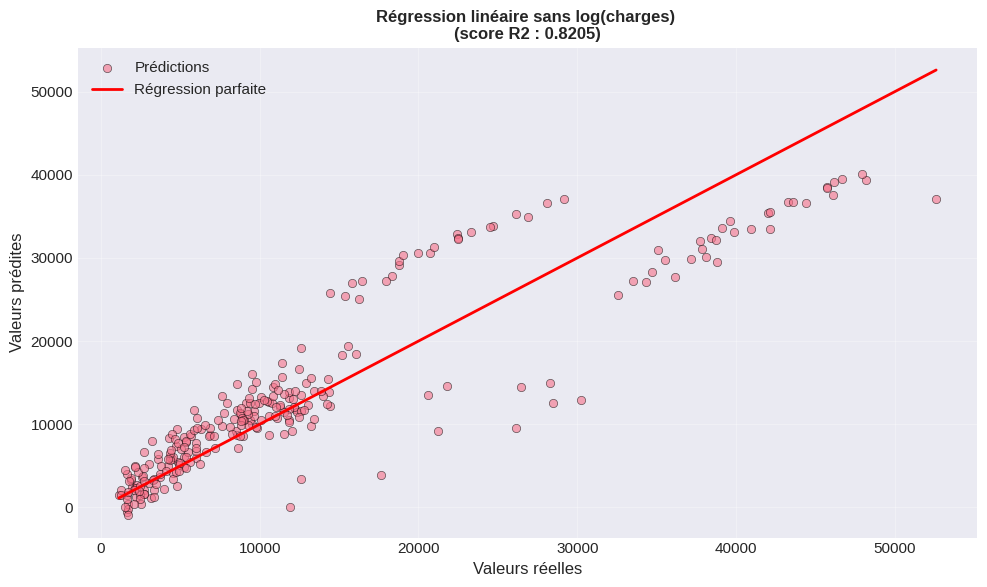

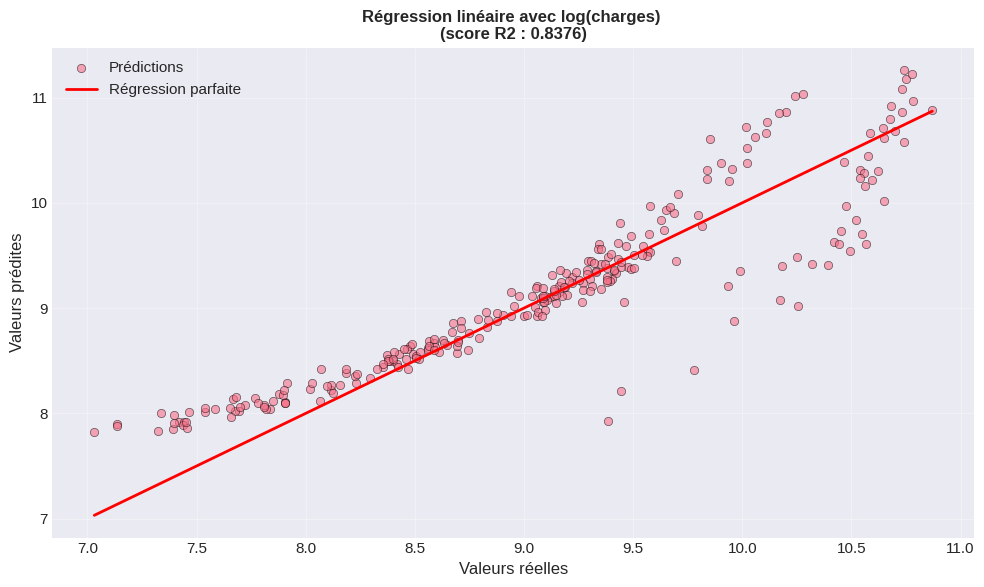

In [38]:
sns.set_palette("husl")

def plot_regression_line(y_true, y_pred, model_name="Régression Linéaire"):
    plt.figure(figsize=(10, 6))


    plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k', linewidth=0.5, label='Prédictions')


    plt.plot([y_true.min(), y_true.max()], 
             [y_true.min(), y_true.max()], 
             'r-', lw=2, label='Régression parfaite')

    plt.xlabel('Valeurs réelles', fontsize=12)
    plt.ylabel('Valeurs prédites', fontsize=12)
    plt.title(f'{model_name}', fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_regression_line(y_test, y_pred, f"Régression linéaire sans log(charges) \n(score R2 : {r2_score(y_test, y_pred):.4f})")

plot_regression_line(y_log_test, y_log_pred, f"Régression linéaire avec log(charges) \n(score R2 : {r2_score(y_log_test, y_log_pred):.4f})")